In [1]:
import math, glob, random, os, time
import pydicom
import cv2
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Config

In [2]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    size = 256
    num_images = 64
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists(), f'{base_path} does not exist'
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    seed = 42
    test_size = 0.1
    clahe=False
    mri_types = ['FLAIR','T1w','T1wCE','T2w']
    batch_size = 4
    num_workers = 7
    epochs = 20
    extra_check_epochs = [19, 20]
    
cfg = Config()

In [3]:
cfg.device

device(type='cuda')

### Functions for loading images

In [4]:
def load_dicom_image(path, img_size=cfg.size, clahe=False):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    max_data = np.max(data)
    min_data = np.min(data)
    if min_data == max_data:
        data = np.zeros((img_size,img_size))
        return data
    data = data - min_data
    if max_data != 0:
        data = data / (max_data - min_data) 
    
    #data = (data * 255).astype(np.uint8)
    data = cv2.resize(data, (img_size, img_size))
    return data

In [5]:
def load_dicom_images_3d(scan_id, num_imgs=cfg.num_images, img_size=cfg.size, mri_type="FLAIR", split="train", clahe=False):

    files = sorted(glob.glob(f"{cfg.base_path}/{split}/{scan_id}/{mri_type}/*.dcm"))
    assert len(files) > 0
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, clahe=False) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    img3d = img3d[:,:,:]
    # Transforms
#     img3d = flip3D(brightness(img3d))
#     if convert_vertical_flag:
#         img3d_vert = convert_vertical(img3d, size=img3d.shape[0])
#         img3d = np.concatenate([img3d, img3d_vert], axis=-1)
    return np.expand_dims(img3d[:,:,:], 0)

In [6]:
sample_image_0 = load_dicom_images_3d("00000")
sample_image_0.shape

(1, 256, 256, 64)

### Seeding

In [7]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### Tabular Data

In [8]:
train_df = pd.read_csv(f"{cfg.base_path}/train_labels.csv")
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [9]:
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


### Train / Test Split

In [10]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=cfg.test_size, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [11]:
len(df_valid) / len(df_train)

0.11281070745697896

In [12]:
df_valid = df_valid.append(pd.DataFrame([{'BraTS21ID': 1, 'MGMT_value': 1}, {'BraTS21ID': 13, 'MGMT_value': 1}]))

In [13]:
len(df_valid) / len(df_train)

0.11663479923518165

### Dataset

In [14]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split, clahe=cfg.clahe)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", clahe=cfg.clahe)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [15]:
df_train.loc[:,"MRI_Type"] = 'FLAIR'
sample_ds = Dataset(df_train['BraTS21ID'], df_train['MGMT_value'], df_train['MRI_Type'])

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
sample_ds[0]['X'].shape

torch.Size([1, 256, 256, 64])

### Model

In [17]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv1x3x3(in_planes, mid_planes, stride=1):
    return nn.Conv3d(in_planes,
                     mid_planes,
                     kernel_size=(1, 3, 3),
                     stride=(1, stride, stride),
                     padding=(0, 1, 1),
                     bias=False)


def conv3x1x1(mid_planes, planes, stride=1):
    return nn.Conv3d(mid_planes,
                     planes,
                     kernel_size=(3, 1, 1),
                     stride=(stride, 1, 1),
                     padding=(1, 0, 0),
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        n_3d_parameters1 = in_planes * planes * 3 * 3 * 3
        n_2p1d_parameters1 = in_planes * 3 * 3 + 3 * planes
        mid_planes1 = n_3d_parameters1 // n_2p1d_parameters1
        self.conv1_s = conv1x3x3(in_planes, mid_planes1, stride)
        self.bn1_s = nn.BatchNorm3d(mid_planes1)
        self.conv1_t = conv3x1x1(mid_planes1, planes, stride)
        self.bn1_t = nn.BatchNorm3d(planes)

        n_3d_parameters2 = planes * planes * 3 * 3 * 3
        n_2p1d_parameters2 = planes * 3 * 3 + 3 * planes
        mid_planes2 = n_3d_parameters2 // n_2p1d_parameters2
        self.conv2_s = conv1x3x3(planes, mid_planes2)
        self.bn2_s = nn.BatchNorm3d(mid_planes2)
        self.conv2_t = conv3x1x1(mid_planes2, planes)
        self.bn2_t = nn.BatchNorm3d(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1_s(x)
        out = self.bn1_s(out)
        out = self.relu(out)
        out = self.conv1_t(out)
        out = self.bn1_t(out)
        out = self.relu(out)

        out = self.conv2_s(out)
        out = self.bn2_s(out)
        out = self.relu(out)
        out = self.conv2_t(out)
        out = self.bn2_t(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)

        n_3d_parameters = planes * planes * 3 * 3 * 3
        n_2p1d_parameters = planes * 3 * 3 + 3 * planes
        mid_planes = n_3d_parameters // n_2p1d_parameters
        self.conv2_s = conv1x3x3(planes, mid_planes, stride)
        self.bn2_s = nn.BatchNorm3d(mid_planes)
        self.conv2_t = conv3x1x1(mid_planes, planes, stride)
        self.bn2_t = nn.BatchNorm3d(planes)

        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2_s(out)
        out = self.bn2_s(out)
        out = self.relu(out)
        out = self.conv2_t(out)
        out = self.bn2_t(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=400):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        n_3d_parameters = 3 * self.in_planes * conv1_t_size * 7 * 7
        n_2p1d_parameters = 3 * 7 * 7 + conv1_t_size * self.in_planes
        mid_planes = n_3d_parameters // n_2p1d_parameters
        self.conv1_s = nn.Conv3d(n_input_channels,
                                 mid_planes,
                                 kernel_size=(1, 7, 7),
                                 stride=(1, 2, 2),
                                 padding=(0, 3, 3),
                                 bias=False)
        self.bn1_s = nn.BatchNorm3d(mid_planes)
        self.conv1_t = nn.Conv3d(mid_planes,
                                 self.in_planes,
                                 kernel_size=(conv1_t_size, 1, 1),
                                 stride=(conv1_t_stride, 1, 1),
                                 padding=(conv1_t_size // 2, 0, 0),
                                 bias=False)
        self.bn1_t = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1_s(x)
        x = self.bn1_s(x)
        x = self.relu(x)
        x = self.conv1_t(x)
        x = self.bn1_t(x)
        x = self.relu(x)

        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [19]:
def create_model():
    return generate_model(34, n_input_channels=1, n_classes=1).to(cfg.device)

In [20]:
# resnet = create_model()

In [21]:
# sample_data = torch.randn([4, 1, 64, 256, 256]).to(cfg.device)

In [22]:
torch.backends.cudnn.enabled = False

In [23]:
# resnet(sample_data)

### Trainer

In [24]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
#         self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader) / 2), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            
            train_loss, train_time = self.train_epoch(train_loader, valid_loader, n_epoch, save_path)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
            self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
        
    def check_and_save(self, valid_loss, valid_auc, valid_time, n_epoch, save_path):
        # if True:
        # if self.best_valid_score < valid_auc: 
        if self.best_valid_score > valid_loss and valid_auc > 0.5: 
            self.save_model(n_epoch, save_path, valid_loss, valid_auc)
            self.info_message(
                 "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                self.best_valid_score, valid_loss, self.lastmodel
            )
            self.best_valid_score = valid_loss
            self.n_patience = 0
        else:
            self.n_patience += 1
            
    def print_valid_message(self, valid_loss, valid_auc, valid_time, n_epoch):
        self.info_message(
            "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
            n_epoch, valid_loss, valid_auc, valid_time
        )
            
    def train_epoch(self, train_loader, valid_loader, n_epoch, save_path):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
            if n_epoch in cfg.extra_check_epochs:
                if step % 3 == 0:
                    valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                    self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
                    self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = torch.sigmoid(self.model(X).squeeze(1))
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean().item(), outputs.std().item())
                print('targets', targets.mean().item(), targets.std().item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [25]:
def loss_func(input, target):
#     return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5
#     return F.binary_cross_entropy_with_logits(input, target) * 0.2 + dice_loss(input, target) * 0.8
    return F.binary_cross_entropy_with_logits(input, target)

In [26]:
def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = create_model()

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        cfg.device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs + 100,
    )
    
    return trainer.lastmodel

In [27]:
!rm -rf {str(cfg.models_path)}/*.pth

(523, 3) (61, 3)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,FLAIR
353,520,1,FLAIR
272,399,0,FLAIR
137,206,0,FLAIR
292,423,0,FLAIR


EPOCH: 1


Train Step 131/131, train_loss: 0.7730


outputs 0.023723382502794266 0.025007713586091995
targets 0.5 0.5658032894134521
outputs 0.3896282911300659 0.3181827962398529
targets 0.5 0.5658032894134521
outputs 0.16932512819766998 0.3163505792617798
targets 0.7450000047683716 0.49000000953674316
outputs 0.007592570967972279 0.009280974976718426
targets 0.5 0.5658032894134521
outputs 0.29334646463394165 0.31400349736213684
targets 0.7450000047683716 0.49000000953674316
outputs 0.03387288376688957 0.04871757701039314
targets 0.2549999952316284 0.49000000953674316
outputs 0.12188916653394699 0.2396494448184967
targets 0.5 0.5658032894134521
outputs 0.3527144193649292 0.24211958050727844
targets 0.7450000047683716 0.49000000953674316
outputs 0.32066109776496887 0.3612162470817566
targets 0.5 0.5658032894134521
outputs 0.09402047097682953 0.06739277392625809
targets 0.2549999952316284 0.49000000953674316
outputs 0.33210355043411255 0.38223937153816223
targets 0.2549999952316284 0.49000000953674316
outputs 0.2816985845565796 0.33428183

Train Step 131/131, train_loss: 0.7630


outputs 1.0 0.0
targets 0.5 0.5658032894134521
outputs 0.7594897747039795 0.27986130118370056
targets 0.5 0.5658032894134521
outputs 0.8650280833244324 0.26994383335113525
targets 0.7450000047683716 0.49000000953674316
outputs 0.9999761581420898 4.7663881559856236e-05
targets 0.5 0.5658032894134521
outputs 0.8637017011642456 0.24471421539783478
targets 0.7450000047683716 0.49000000953674316
outputs 0.9999971389770508 4.900043222733075e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.9473552703857422 0.10465952754020691
targets 0.5 0.5658032894134521
outputs 0.8411760330200195 0.2555747330188751
targets 0.7450000047683716 0.49000000953674316
outputs 0.8469290733337402 0.26054900884628296
targets 0.5 0.5658032894134521
outputs 0.9469795823097229 0.09924933314323425
targets 0.2549999952316284 0.49000000953674316
outputs 0.7431837320327759 0.29732075333595276
targets 0.2549999952316284 0.49000000953674316
outputs 0.8925419449806213 0.20157687366008759
targets 0.5 0.565803289413

Train Step 131/131, train_loss: 0.7477


outputs 1.0 5.960464477539063e-08
targets 0.5 0.5658032894134521
outputs 0.7376511096954346 0.17504236102104187
targets 0.5 0.5658032894134521
outputs 0.9140312075614929 0.17193759977817535
targets 0.7450000047683716 0.49000000953674316
outputs 0.9999997615814209 5.364418029785156e-07
targets 0.5 0.5658032894134521
outputs 0.826335072517395 0.20053106546401978
targets 0.7450000047683716 0.49000000953674316
outputs 1.0 0.0, valid_loss: 0.6945
targets 0.2549999952316284 0.49000000953674316
outputs 0.9070298671722412 0.18593329191207886
targets 0.5 0.5658032894134521
outputs 0.7394217252731323 0.17372724413871765
targets 0.7450000047683716 0.49000000953674316
outputs 0.8273221850395203 0.19939379394054413
targets 0.5 0.5658032894134521
outputs 0.9725704193115234 0.05453033372759819
targets 0.2549999952316284 0.49000000953674316
outputs 0.827877402305603 0.19875028729438782
targets 0.2549999952316284 0.49000000953674316
outputs 0.8267042636871338 0.2001105397939682
targets 0.5 0.5658032894

Train Step 131/131, train_loss: 0.7814


outputs 0.6372290849685669 0.018195005133748055
targets 0.5 0.5658032894134521
outputs 0.5800259113311768 0.02919071353971958
targets 0.5 0.5658032894134521
outputs 0.6105301976203918 0.03481833636760712
targets 0.7450000047683716 0.49000000953674316
outputs 0.6784339547157288 0.04485948756337166
targets 0.5 0.5658032894134521
outputs 0.6100706458091736 0.06280265003442764
targets 0.7450000047683716 0.49000000953674316
outputs 0.6923377513885498 0.05906405299901962
targets 0.2549999952316284 0.49000000953674316
outputs 0.6471269130706787 0.06053876504302025
targets 0.5 0.5658032894134521
outputs 0.591023862361908 0.011074132286012173
targets 0.7450000047683716 0.49000000953674316
outputs 0.5988309383392334 0.0569300651550293
targets 0.5 0.5658032894134521
outputs 0.6381245255470276 0.021355371922254562
targets 0.2549999952316284 0.49000000953674316
outputs 0.5732462406158447 0.02592436410486698
targets 0.2549999952316284 0.49000000953674316
outputs 0.6305936574935913 0.1123480275273323

Train Step 131/131, train_loss: 0.7483


outputs 0.6586772203445435 0.00040721811819821596
targets 0.5 0.5658032894134521
outputs 0.650810956954956 0.016071978956460953
targets 0.5 0.5658032894134521
outputs 0.6586624383926392 0.0005452593904919922
targets 0.7450000047683716 0.49000000953674316
outputs 0.6503810882568359 0.013690367341041565
targets 0.5 0.5658032894134521
outputs 0.652671217918396 0.01251155324280262
targets 0.7450000047683716 0.49000000953674316
outputs 0.6691147685050964 0.05249343812465668
targets 0.2549999952316284 0.49000000953674316
outputs 0.6585451364517212 0.021846527233719826
targets 0.5 0.5658032894134521
outputs 0.6402362585067749 0.011850294657051563
targets 0.7450000047683716 0.49000000953674316
outputs 0.6587967872619629 0.00013330507499631494
targets 0.5 0.5658032894134521
outputs 0.6484783887863159 0.03418433293700218
targets 0.2549999952316284 0.49000000953674316
outputs 0.6577835083007812 0.002277781255543232
targets 0.2549999952316284 0.49000000953674316
outputs 0.6535271406173706 0.019172

Train Step 131/131, train_loss: 0.7446


outputs 0.48016366362571716 0.00018430491036269814
targets 0.5 0.5658032894134521
outputs 0.4803355932235718 9.837072138907388e-05
targets 0.5 0.5658032894134521
outputs 0.5336230397224426 0.10675519704818726
targets 0.7450000047683716 0.49000000953674316
outputs 0.4796443581581116 0.001193328876979649
targets 0.5 0.5658032894134521
outputs 0.480132520198822 0.00034505437361076474
targets 0.7450000047683716 0.49000000953674316
outputs 0.4996430575847626 0.0389726497232914
targets 0.2549999952316284 0.49000000953674316
outputs 0.4767496585845947 0.0068252733908593655
targets 0.5 0.5658032894134521
outputs 0.49292054772377014 0.025170888751745224
targets 0.7450000047683716 0.49000000953674316
outputs 0.48976171016693115 0.018924882635474205
targets 0.5 0.5658032894134521
outputs 0.4973536729812622 0.04425797238945961
targets 0.2549999952316284 0.49000000953674316
outputs 0.48306670784950256 0.005507004447281361
targets 0.2549999952316284 0.49000000953674316
outputs 0.4795553684234619 0.0

Train Step 131/131, train_loss: 0.7291


outputs 0.5152689814567566 0.0004868627875111997
targets 0.5 0.5658032894134521
outputs 0.5552433729171753 0.0776536762714386
targets 0.5 0.5658032894134521
outputs 0.5168305039405823 0.0041096946224570274
targets 0.7450000047683716 0.49000000953674316
outputs 0.5098460912704468 0.0052481889724731445
targets 0.5 0.5658032894134521
outputs 0.5260533094406128 0.021547313779592514
targets 0.7450000047683716 0.49000000953674316
outputs 0.5125912427902222 0.004120212979614735
targets 0.2549999952316284 0.49000000953674316
outputs 0.6058200597763062 0.18049836158752441
targets 0.5 0.5658032894134521
outputs 0.51549232006073 0.00137042673304677
targets 0.7450000047683716 0.49000000953674316
outputs 0.5593395829200745 0.08646565675735474
targets 0.5 0.5658032894134521
outputs 0.514494776725769 0.0015519177541136742
targets 0.2549999952316284 0.49000000953674316
outputs 0.5140937566757202 0.0031134227756410837
targets 0.2549999952316284 0.49000000953674316
outputs 0.5192952156066895 0.016933709

outputs 0.4648563265800476 0.0004438154574017972
targets 0.5 0.5658032894134521
outputs 0.483997642993927 0.03555069863796234
targets 0.5 0.5658032894134521
outputs 0.46403390169143677 0.002249892335385084
targets 0.7450000047683716 0.49000000953674316
outputs 0.4591420888900757 0.005314171779900789
targets 0.5 0.5658032894134521
outputs 0.4704194664955139 0.011385303921997547
targets 0.7450000047683716 0.49000000953674316
outputs 0.46208077669143677 0.0043070679530501366
targets 0.2549999952316284 0.49000000953674316
outputs 0.5098385214805603 0.08937479555606842
targets 0.5 0.5658032894134521
outputs 0.46515971422195435 0.0015549215022474527
targets 0.7450000047683716 0.49000000953674316
outputs 0.48770710825920105 0.04393165931105614
targets 0.5 0.5658032894134521
outputs 0.46404916048049927 0.0016984597314149141
targets 0.2549999952316284 0.49000000953674316
outputs 0.463788777589798 0.0031170970760285854
targets 0.2549999952316284 0.49000000953674316
outputs 0.46325957775115967 0.

outputs 0.46562984585762024 0.0001627247256692499
targets 0.5 0.5658032894134521
outputs 0.4661203622817993 0.00022437454026658088
targets 0.5 0.5658032894134521
outputs 0.46470606327056885 0.0014208850916475058
targets 0.7450000047683716 0.49000000953674316
outputs 0.46429508924484253 0.0014127426547929645
targets 0.5 0.5658032894134521
outputs 0.46590954065322876 0.00044235269888304174
targets 0.7450000047683716 0.49000000953674316
outputs 0.46439844369888306 0.0023350606206804514
targets 0.2549999952316284 0.49000000953674316
outputs 0.46445542573928833 0.0028666709549725056
targets 0.5 0.5658032894134521
outputs 0.465946227312088 0.0005179051076993346
targets 0.7450000047683716 0.49000000953674316
outputs 0.46596235036849976 0.00030511972727254033
targets 0.5 0.5658032894134521
outputs 0.46559107303619385 0.0003522432816680521
targets 0.2549999952316284 0.49000000953674316
outputs 0.46538394689559937 0.0012016462860628963
targets 0.2549999952316284 0.49000000953674316
outputs 0.463

outputs 0.37730127573013306 9.006749314721674e-05
targets 0.5 0.5658032894134521
outputs 0.3776152729988098 9.601778583601117e-05
targets 0.5 0.5658032894134521
outputs 0.3771933913230896 0.00039524471503682435
targets 0.7450000047683716 0.49000000953674316
outputs 0.3768719732761383 0.000450730265583843
targets 0.5 0.5658032894134521
outputs 0.377453088760376 0.000226593081606552
targets 0.7450000047683716 0.49000000953674316
outputs 0.3769000172615051 0.0007208238821476698
targets 0.2549999952316284 0.49000000953674316
outputs 0.37705445289611816 0.0007329890504479408
targets 0.5 0.5658032894134521
outputs 0.37751275300979614 0.00015337762306444347
targets 0.7450000047683716 0.49000000953674316
outputs 0.3775177299976349 0.000196895663975738
targets 0.5 0.5658032894134521
outputs 0.37729018926620483 0.00011307989188935608
targets 0.2549999952316284 0.49000000953674316
outputs 0.3773089051246643 0.00041806293302215636
targets 0.2549999952316284 0.49000000953674316
outputs 0.3768001198

outputs 0.2902767062187195 3.519287929520942e-05
targets 0.5 0.5658032894134521
outputs 0.2903200387954712 3.045618359465152e-05
targets 0.5 0.5658032894134521
outputs 0.2902318835258484 9.648060222389176e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.29009029269218445 0.00021316854690667242
targets 0.5 0.5658032894134521
outputs 0.2902714014053345 5.3154100896790624e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.29012393951416016 0.0002510995836928487
targets 0.2549999952316284 0.49000000953674316
outputs 0.2902708351612091 2.4527225832571276e-05
targets 0.5 0.5658032894134521
outputs 0.2902742922306061 3.3517393603688106e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.2903032600879669 7.039434422040358e-05
targets 0.5 0.5658032894134521
outputs 0.2902047634124756 7.853244460420683e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.29021498560905457 0.00010416397708468139
targets 0.2549999952316284 0.49000000953674316
outputs 0.290010

outputs 0.3318749964237213 3.63239596481435e-05
targets 0.5 0.5658032894134521
outputs 0.3319385051727295 2.4996252250275575e-05
targets 0.5 0.5658032894134521
outputs 0.33187538385391235 7.056462345644832e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.3317872881889343 0.00010149683657800779
targets 0.5 0.5658032894134521
outputs 0.3319075405597687 4.4389798858901486e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.33180493116378784 0.00010763307363959029
targets 0.2549999952316284 0.49000000953674316
outputs 0.33187758922576904 5.9825943026226014e-05
targets 0.5 0.5658032894134521
outputs 0.33192452788352966 2.1906136680627242e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.331920325756073 5.4977899708319455e-05
targets 0.5 0.5658032894134521
outputs 0.33185631036758423 3.730815296876244e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.3318798542022705 9.205064998241141e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.3317

outputs 0.38659465312957764 4.5636083086719736e-05
targets 0.5 0.5658032894134521
outputs 0.38671666383743286 5.0192091293865815e-05
targets 0.5 0.5658032894134521
outputs 0.3866317570209503 9.412180952494964e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.38651901483535767 9.559947648085654e-05
targets 0.5 0.5658032894134521
outputs 0.386665940284729 8.357152546523139e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.3865225911140442 9.022986341733485e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.38660216331481934 8.551061182515696e-05
targets 0.5 0.5658032894134521
outputs 0.3866944909095764 4.798192094312981e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.38668912649154663 9.075139678316191e-05
targets 0.5 0.5658032894134521
outputs 0.3865836262702942 4.6139797632349655e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.3866531252861023 0.00012221951328683645
targets 0.2549999952316284 0.49000000953674316
outputs 0.386579

outputs 0.45810768008232117 5.400218287832104e-05
targets 0.5 0.5658032894134521
outputs 0.45829007029533386 6.64638209855184e-05
targets 0.5 0.5658032894134521
outputs 0.4581664204597473 0.00012869367492385209
targets 0.7450000047683716 0.49000000953674316
outputs 0.4580375552177429 9.65000144788064e-05
targets 0.5 0.5658032894134521
outputs 0.45822176337242126 0.00011961874406551942
targets 0.7450000047683716 0.49000000953674316
outputs 0.45803314447402954 8.433756738668308e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4581196904182434 0.0001504881220171228
targets 0.5 0.5658032894134521
outputs 0.4582614600658417 7.587553409393877e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4582456946372986 0.00012559967581182718
targets 0.5 0.5658032894134521
outputs 0.45811891555786133 4.972445094608702e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4582057297229767 0.00016605728887952864
targets 0.2549999952316284 0.49000000953674316
outputs 0.4581349

outputs 0.5352864861488342 4.097498094779439e-05
targets 0.5 0.5658032894134521
outputs 0.5353193879127502 1.8941183952847496e-05
targets 0.5 0.5658032894134521
outputs 0.5352795124053955 4.744669422507286e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5352578163146973 4.248028199071996e-05
targets 0.5 0.5658032894134521
outputs 0.5353059768676758 2.836733438016381e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5352503061294556 5.400050213211216e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.535252034664154 8.267994417110458e-05
targets 0.5 0.5658032894134521
outputs 0.5353182554244995 1.8208673282060772e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5353075265884399 3.0646526283817366e-05
targets 0.5 0.5658032894134521
outputs 0.5352910161018372 8.493749191984534e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.535287618637085 5.418013097369112e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5352520942687

outputs 0.665130615234375 2.038531056314241e-05
targets 0.5 0.5658032894134521
outputs 0.6651378273963928 8.110649105219636e-06
targets 0.5 0.5658032894134521
outputs 0.665099561214447 3.5946181014878675e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6651319265365601 2.2033411369193345e-05
targets 0.5 0.5658032894134521
outputs 0.6651337742805481 1.123591027862858e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.665111780166626 4.4585129217011854e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6650600433349609 0.00011841215018648654
targets 0.5 0.5658032894134521
outputs 0.6651409864425659 5.604210400633747e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.6651315093040466 1.1081388947786763e-05
targets 0.5 0.5658032894134521
outputs 0.6651610732078552 4.882505163550377e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6651206016540527 2.377805685682688e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.665081739425

outputs 0.738383412361145 1.915659595397301e-05
targets 0.5 0.5658032894134521
outputs 0.7385144233703613 3.0178458473528735e-05
targets 0.5 0.5658032894134521
outputs 0.7384372353553772 6.794522778363898e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.7384071350097656 4.402038757689297e-05
targets 0.5 0.5658032894134521
outputs 0.7384725213050842 7.528618152718991e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.7383886575698853 2.6867384804063477e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.7384308576583862 9.22947729122825e-05
targets 0.5 0.5658032894134521
outputs 0.7385014295578003 5.6432123528793454e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.738473653793335 8.391493611270562e-05
targets 0.5 0.5658032894134521
outputs 0.7384492754936218 4.843053102376871e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.7384618520736694 9.242340456694365e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.73847424983978

outputs 0.6095862984657288 3.926422505173832e-05
targets 0.5 0.5658032894134521
outputs 0.6097167730331421 4.238273686496541e-05
targets 0.5 0.5658032894134521
outputs 0.6096530556678772 7.142465619836003e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6095888018608093 2.634068914630916e-05
targets 0.5 0.5658032894134521
outputs 0.6096760034561157 7.63328789616935e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.609569787979126 8.765835445956327e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.6096374988555908 7.137480133678764e-05
targets 0.5 0.5658032894134521
outputs 0.6097010374069214 5.757817780249752e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6096794605255127 9.015138493850827e-05
targets 0.5 0.5658032894134521
outputs 0.6096195578575134 3.053171167266555e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6096693873405457 0.00010198624659096822
targets 0.2549999952316284 0.49000000953674316
outputs 0.609674811363220

outputs 0.6266220808029175 3.5088163713226095e-05
targets 0.5 0.5658032894134521
outputs 0.6267463564872742 3.6329383874544874e-05
targets 0.5 0.5658032894134521
outputs 0.6266729831695557 7.006871601333842e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6266316175460815 3.461239975877106e-05
targets 0.5 0.5658032894134521
outputs 0.6267078518867493 6.782676791772246e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6266194581985474 2.2906273443368264e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6266649961471558 7.908284169388935e-05
targets 0.5 0.5658032894134521
outputs 0.6267284750938416 5.9525686083361506e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6267078518867493 8.166014595190063e-05
targets 0.5 0.5658032894134521
outputs 0.6266746520996094 3.371111233718693e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6266923546791077 9.752823825692758e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6266990303

outputs 0.6430264711380005 3.9655576983932406e-05
targets 0.5 0.5658032894134521
outputs 0.6431503295898438 3.8500609662150964e-05
targets 0.5 0.5658032894134521
outputs 0.6430761814117432 7.299820572370663e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6430292129516602 3.062554606003687e-05
targets 0.5 0.5658032894134521
outputs 0.6431112289428711 6.89394655637443e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6430175304412842 2.417758878436871e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6430644989013672 8.152840018738061e-05
targets 0.5 0.5658032894134521
outputs 0.6431329250335693 5.8337380323791876e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6431128978729248 8.19871129351668e-05
targets 0.5 0.5658032894134521
outputs 0.6430732607841492 3.0386017897399142e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6430960297584534 0.00010046507668448612
targets 0.2549999952316284 0.49000000953674316
outputs 0.64309436082

outputs 0.6417091488838196 4.0777773392619565e-05
targets 0.5 0.5658032894134521
outputs 0.6418203115463257 3.662381641333923e-05
targets 0.5 0.5658032894134521
outputs 0.6417531371116638 6.787084566894919e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.641710638999939 2.991375367855653e-05
targets 0.5 0.5658032894134521
outputs 0.6417855024337769 6.228525307960808e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.641697883605957 2.302799839526415e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6417379379272461 7.920504140201956e-05
targets 0.5 0.5658032894134521
outputs 0.6418043375015259 5.408477954915725e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6417858600616455 7.553659816039726e-05
targets 0.5 0.5658032894134521
outputs 0.6417475938796997 2.5794675821089186e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6417710781097412 9.272191527998075e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.64176589250564

outputs 0.6103342771530151 2.9052542231511325e-05
targets 0.5 0.5658032894134521
outputs 0.6104152202606201 2.571079858171288e-05
targets 0.5 0.5658032894134521
outputs 0.6103633046150208 4.991582682123408e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6103415489196777 2.6480891392566264e-05
targets 0.5 0.5658032894134521
outputs 0.6103907823562622 4.305039328755811e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6103345155715942 2.2174785044626333e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6103543043136597 6.635512545472011e-05
targets 0.5 0.5658032894134521
outputs 0.61040198802948 4.258429544279352e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6103872060775757 5.50394288438838e-05
targets 0.5 0.5658032894134521
outputs 0.6103692650794983 2.4258162738988176e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6103770136833191 6.711402966175228e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6103765964508

outputs 0.5861817002296448 2.686361585801933e-05
targets 0.5 0.5658032894134521
outputs 0.5862559676170349 2.2334608729579486e-05
targets 0.5 0.5658032894134521
outputs 0.5862066745758057 4.5115360990166664e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5861959457397461 2.8449039746192284e-05
targets 0.5 0.5658032894134521
outputs 0.5862340927124023 3.7438745494000614e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.586192786693573 2.877855149563402e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5861992239952087 6.885975744808093e-05
targets 0.5 0.5658032894134521
outputs 0.58624267578125 4.125955456402153e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5862278938293457 4.996423012926243e-05
targets 0.5 0.5658032894134521
outputs 0.5862225890159607 2.8885671781608835e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5862189531326294 6.016386396368034e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.586221992969

outputs 0.5824130177497864 1.8811191694112495e-05
targets 0.5 0.5658032894134521
outputs 0.5824567079544067 1.3130192201060709e-05
targets 0.5 0.5658032894134521
outputs 0.582426130771637 2.813644277921412e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.582423985004425 1.9268623873358592e-05
targets 0.5 0.5658032894134521
outputs 0.5824445486068726 1.997130675590597e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5824217796325684 2.1250343706924468e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5824204087257385 5.1713122957153246e-05
targets 0.5 0.5658032894134521
outputs 0.5824480056762695 2.5590716177248396e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.582438588142395 2.925548869825434e-05
targets 0.5 0.5658032894134521
outputs 0.5824397206306458 2.1244715753709897e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.582433819770813 3.572775312932208e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.58243203163

outputs 0.5856343507766724 1.7948241293197498e-05
targets 0.5 0.5658032894134521
outputs 0.5856810808181763 1.3153823601896875e-05
targets 0.5 0.5658032894134521
outputs 0.5856492519378662 2.8650867534452118e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5856438875198364 1.9092894945060834e-05
targets 0.5 0.5658032894134521
outputs 0.5856683254241943 2.0670411686296575e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5856430530548096 2.154450339730829e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.585647702217102 4.9199286877410486e-05
targets 0.5 0.5658032894134521
outputs 0.58567214012146 2.6082487238454632e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5856621265411377 3.073996413149871e-05
targets 0.5 0.5658032894134521
outputs 0.5856622457504272 2.2279198674368672e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5856568813323975 3.760659456020221e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.585656881

outputs 0.5609760284423828 1.2118129234295338e-05
targets 0.5 0.5658032894134521
outputs 0.5609967112541199 6.501461484731408e-06
targets 0.5 0.5658032894134521
outputs 0.5609802007675171 1.6267336832243018e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5609847903251648 1.1313295544823632e-05
targets 0.5 0.5658032894134521
outputs 0.5609920024871826 7.13975578037207e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5609861016273499 1.623758907953743e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5609769821166992 3.996862142230384e-05
targets 0.5 0.5658032894134521
outputs 0.5609906911849976 1.490342583565507e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5609855651855469 1.5289684597519226e-05
targets 0.5 0.5658032894134521
outputs 0.5609931349754333 1.5578947568428703e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5609831809997559 1.9370057998457924e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.560982346

outputs 0.5263308882713318 6.148096872493625e-06
targets 0.5 0.5658032894134521
outputs 0.5263261198997498 3.5438458780845394e-06
targets 0.5 0.5658032894134521
outputs 0.5263246297836304 8.585241630498786e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5263423919677734 2.889749794121599e-06
targets 0.5 0.5658032894134521
outputs 0.5263293981552124 8.925584552343935e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5263426303863525 9.372471140522975e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.526322066783905 3.169782939949073e-05
targets 0.5 0.5658032894134521
outputs 0.5263255834579468 2.830122411978664e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5263235569000244 6.401605332939653e-06
targets 0.5 0.5658032894134521
outputs 0.526339054107666 1.2605666597664822e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.526324987411499 9.328904525318649e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.526323437690734

outputs 0.5235201716423035 5.926242465648102e-06
targets 0.5 0.5658032894134521
outputs 0.5235263109207153 3.722070232470287e-06
targets 0.5 0.5658032894134521
outputs 0.5235174894332886 9.95361915556714e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5235286951065063 6.3015295381774195e-06
targets 0.5 0.5658032894134521
outputs 0.5235260725021362 3.959860350732924e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5235333442687988 1.4103228750173002e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5235158205032349 3.784741784329526e-05
targets 0.5 0.5658032894134521
outputs 0.5235229134559631 7.004877261351794e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5235205292701721 5.249327386991354e-06
targets 0.5 0.5658032894134521
outputs 0.5235345959663391 1.5534549675066955e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5235193967819214 9.234424396709073e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.523516714572

outputs 0.5303142070770264 8.421463462582324e-06
targets 0.5 0.5658032894134521
outputs 0.5303356051445007 5.31830210093176e-06
targets 0.5 0.5658032894134521
outputs 0.5303179621696472 1.4210530935088173e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5303264856338501 1.3516615581465885e-05
targets 0.5 0.5658032894134521
outputs 0.5303313732147217 4.788013029610738e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.530331015586853 2.194025910284836e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5303192734718323 4.253322185832076e-05
targets 0.5 0.5658032894134521
outputs 0.5303303599357605 1.3665743608726189e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5303248763084412 1.3216224033385515e-05
targets 0.5 0.5658032894134521
outputs 0.5303380489349365 2.219059933850076e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5303225517272949 1.5698838979005814e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.53032302856

outputs 0.5221765041351318 8.535265806131065e-06
targets 0.5 0.5658032894134521
outputs 0.5221951007843018 5.184633209864842e-06
targets 0.5 0.5658032894134521
outputs 0.5221788883209229 1.3275521268951707e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5221878290176392 1.2487777894421015e-05
targets 0.5 0.5658032894134521
outputs 0.5221917629241943 3.5237387692177435e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.522193431854248 2.1659845515387133e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5221809148788452 4.163630728726275e-05
targets 0.5 0.5658032894134521
outputs 0.5221899747848511 1.2757134754792787e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.522185206413269 1.1783668924181256e-05
targets 0.5 0.5658032894134521
outputs 0.5221990942955017 2.1469948478625156e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5221827030181885 1.4768747860216536e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52218252

outputs 0.5182439088821411 9.115354259847663e-06
targets 0.5 0.5658032894134521
outputs 0.5182660818099976 6.1709761212114245e-06
targets 0.5 0.5658032894134521
outputs 0.5182476043701172 1.5295938283088617e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5182536244392395 1.1822898159152828e-05
targets 0.5 0.5658032894134521
outputs 0.5182613134384155 5.44146087122499e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5182590484619141 2.0379602574394085e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5182486772537231 4.236568202031776e-05
targets 0.5 0.5658032894134521
outputs 0.51826012134552 1.4516780538542662e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5182552337646484 1.4318788089440204e-05
targets 0.5 0.5658032894134521
outputs 0.5182661414146423 1.9960527424700558e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5182517766952515 1.8163824279326946e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.518250405

outputs 0.5201228857040405 1.1876814824063331e-05
targets 0.5 0.5658032894134521
outputs 0.5201576948165894 9.289723493566271e-06
targets 0.5 0.5658032894134521
outputs 0.5201316475868225 2.1599975298158824e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5201330184936523 1.553512083773967e-05
targets 0.5 0.5658032894134521
outputs 0.5201491117477417 1.1787135917984415e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5201382637023926 2.3477774448110722e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.520133376121521 4.758851355290972e-05
targets 0.5 0.5658032894134521
outputs 0.5201500058174133 2.055527875199914e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5201429128646851 2.2237605662667193e-05
targets 0.5 0.5658032894134521
outputs 0.520150363445282 2.2733709556632675e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5201377868652344 2.7342879548086785e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.520137548

outputs 0.5227649807929993 1.3843940905644558e-05
targets 0.5 0.5658032894134521
outputs 0.5228086709976196 1.1450712918303907e-05
targets 0.5 0.5658032894134521
outputs 0.5227779150009155 2.5516066671116278e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.522777259349823 1.90086957445601e-05
targets 0.5 0.5658032894134521
outputs 0.5227974653244019 1.645242991799023e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5227817893028259 2.6667421479942277e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.522780179977417 5.0632206693990156e-05
targets 0.5 0.5658032894134521
outputs 0.522800087928772 2.4599827156635e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5227911472320557 2.7873686121893115e-05
targets 0.5 0.5658032894134521
outputs 0.5227971076965332 2.562404733907897e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5227852463722229 3.322064003441483e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52278685569763

outputs 0.5172066688537598 1.5362338672275655e-05
targets 0.5 0.5658032894134521
outputs 0.5172584652900696 1.3778731954516843e-05
targets 0.5 0.5658032894134521
outputs 0.5172227621078491 2.9886821721447632e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5172186493873596 2.0269801098038442e-05
targets 0.5 0.5658032894134521
outputs 0.5172446966171265 2.0823415979975834e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.51722252368927 2.7581541871768422e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5172246694564819 5.5011238146107644e-05
targets 0.5 0.5658032894134521
outputs 0.5172486305236816 2.848018084478099e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5172384977340698 3.29944487020839e-05
targets 0.5 0.5658032894134521
outputs 0.5172414779663086 2.6684481781558134e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5172312259674072 3.967191878473386e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.517232418

outputs 0.5294356942176819 1.7690601453068666e-05
targets 0.5 0.5658032894134521
outputs 0.5294855833053589 1.4312935491034295e-05
targets 0.5 0.5658032894134521
outputs 0.5294517278671265 3.0026170861674473e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5294458866119385 1.880535091913771e-05
targets 0.5 0.5658032894134521
outputs 0.5294723510742188 2.0765226508956403e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.529448926448822 2.5915947844623588e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5294516682624817 5.311431596055627e-05
targets 0.5 0.5658032894134521
outputs 0.5294763445854187 2.800067341013346e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5294663906097412 3.3327331038890406e-05
targets 0.5 0.5658032894134521
outputs 0.5294667482376099 2.370009860896971e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5294595956802368 3.9883852878119797e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52945905

outputs 0.541599690914154 1.8519627701607533e-05
targets 0.5 0.5658032894134521
outputs 0.5416494011878967 1.473645716032479e-05
targets 0.5 0.5658032894134521
outputs 0.5416165590286255 3.0071218134253286e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5416066646575928 1.613251879462041e-05
targets 0.5 0.5658032894134521
outputs 0.5416358113288879 2.121167563018389e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5416080951690674 2.338558988412842e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5416138768196106 5.1482969865901396e-05
targets 0.5 0.5658032894134521
outputs 0.5416396856307983 2.7749243599828333e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5416304469108582 3.4064614737872034e-05
targets 0.5 0.5658032894134521
outputs 0.5416264533996582 2.0316982045187615e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5416239500045776 4.054780220030807e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.541621088

outputs 0.5553053617477417 2.2923715732758865e-05
targets 0.5 0.5658032894134521
outputs 0.5553673505783081 1.895752575364895e-05
targets 0.5 0.5658032894134521
outputs 0.5553276538848877 3.727226430783048e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5553123950958252 1.8343211195315234e-05
targets 0.5 0.5658032894134521
outputs 0.5553503036499023 2.83823592326371e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5553120970726013 2.3503511329181492e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5553230047225952 5.716255691368133e-05
targets 0.5 0.5658032894134521
outputs 0.5553566217422485 3.3080767025239766e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5553451776504517 4.196273584966548e-05
targets 0.5 0.5658032894134521
outputs 0.5553356409072876 2.12565155379707e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5553368330001831 5.0850550906034186e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.55533373355

outputs 0.5748195648193359 2.36901414609747e-05
targets 0.5 0.5658032894134521
outputs 0.5749033689498901 2.3198103008326143e-05
targets 0.5 0.5658032894134521
outputs 0.5748511552810669 4.808181620319374e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5748277306556702 2.289483200001996e-05
targets 0.5 0.5658032894134521
outputs 0.5748789310455322 4.057345722685568e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.574827253818512 2.7297593987896107e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5748485922813416 6.430171197280288e-05
targets 0.5 0.5658032894134521
outputs 0.5748904943466187 4.094533869647421e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5748748779296875 5.401332600740716e-05
targets 0.5 0.5658032894134521
outputs 0.5748605728149414 2.873662015190348e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5748643279075623 6.53403258183971e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.574864745140075

outputs 0.5968042612075806 2.3753565983497538e-05
targets 0.5 0.5658032894134521
outputs 0.5968950986862183 2.5029621610883623e-05
targets 0.5 0.5658032894134521
outputs 0.5968383550643921 5.1805927796522155e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5968127250671387 2.474570464983117e-05
targets 0.5 0.5658032894134521
outputs 0.5968673229217529 4.611149415723048e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5968104004859924 2.679375211300794e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5968347787857056 6.701068923575804e-05
targets 0.5 0.5658032894134521
outputs 0.5968806743621826 4.4087282731197774e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5968645811080933 5.811446681036614e-05
targets 0.5 0.5658032894134521
outputs 0.5968471765518188 3.0385373975150287e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5968530178070068 7.046967220958322e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.596854567

outputs 0.5987393856048584 2.163610224670265e-05
targets 0.5 0.5658032894134521
outputs 0.5988314151763916 2.44598832068732e-05
targets 0.5 0.5658032894134521
outputs 0.5987741947174072 5.146221519680694e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5987482666969299 2.5579318389645778e-05
targets 0.5 0.5658032894134521
outputs 0.598802924156189 4.715605973615311e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5987471342086792 2.5975979951908812e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.598772406578064 6.507211219286546e-05
targets 0.5 0.5658032894134521
outputs 0.5988166332244873 4.422846177476458e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5988009572029114 5.761477950727567e-05
targets 0.5 0.5658032894134521
outputs 0.598784327507019 3.174123048665933e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5987892150878906 6.996896263444796e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5987935066223145

outputs 0.6072624921798706 2.1448411644087173e-05
targets 0.5 0.5658032894134521
outputs 0.6073572635650635 2.4964067051769234e-05
targets 0.5 0.5658032894134521
outputs 0.6072983741760254 5.267824963084422e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6072707772254944 2.6179775886703283e-05
targets 0.5 0.5658032894134521
outputs 0.6073274612426758 4.907335096504539e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6072697639465332 2.5751805878826417e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6072972416877747 6.473153916886076e-05
targets 0.5 0.5658032894134521
outputs 0.6073418855667114 4.51991509180516e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6073260307312012 5.903289275011048e-05
targets 0.5 0.5658032894134521
outputs 0.6073085069656372 3.228619971196167e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6073138117790222 7.189108146121725e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.60731869935

outputs 0.6164144277572632 2.185455377912149e-05
targets 0.5 0.5658032894134521
outputs 0.6165117621421814 2.5522969735902734e-05
targets 0.5 0.5658032894134521
outputs 0.6164519786834717 5.3963784012012184e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6164216995239258 2.6111301849596202e-05
targets 0.5 0.5658032894134521
outputs 0.6164807081222534 5.117629552842118e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6164201498031616 2.4974204279715195e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6164497137069702 6.490509258583188e-05
targets 0.5 0.5658032894134521
outputs 0.6164959669113159 4.5965396566316485e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.616479754447937 6.0877049691043794e-05
targets 0.5 0.5658032894134521
outputs 0.6164605617523193 3.2159041438717395e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.616467297077179 7.403687050100416e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.616471707

outputs 0.6234176754951477 2.332111216674093e-05
targets 0.5 0.5658032894134521
outputs 0.6235216856002808 2.7588754164753482e-05
targets 0.5 0.5658032894134521
outputs 0.6234583258628845 5.770617281086743e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6234237551689148 2.58788641076535e-05
targets 0.5 0.5658032894134521
outputs 0.6234883069992065 5.544595842366107e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6234208345413208 2.4311913875862956e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6234540343284607 6.822626164648682e-05
targets 0.5 0.5658032894134521
outputs 0.623505175113678 4.817364606424235e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6234879493713379 6.508722435683012e-05
targets 0.5 0.5658032894134521
outputs 0.623464822769165 3.255506817367859e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6234747171401978 7.919416384538636e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.623477160930633

outputs 0.6383519172668457 2.8703530915663578e-05
targets 0.5 0.5658032894134521
outputs 0.638458788394928 3.069267768296413e-05
targets 0.5 0.5658032894134521
outputs 0.6383951306343079 6.065567140467465e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6383562088012695 2.521889291529078e-05
targets 0.5 0.5658032894134521
outputs 0.6384245157241821 5.8103774790652096e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6383509635925293 2.274749567732215e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.638386607170105 6.964857311686501e-05
targets 0.5 0.5658032894134521
outputs 0.6384423971176147 4.94076193717774e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6384246349334717 6.879297870909795e-05
targets 0.5 0.5658032894134521
outputs 0.6383954286575317 2.998695163114462e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6384114027023315 8.342442743014544e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.638410508632659

outputs 0.6383970975875854 2.875093741749879e-05
targets 0.5 0.5658032894134521
outputs 0.6385025978088379 3.086816650466062e-05
targets 0.5 0.5658032894134521
outputs 0.6384402513504028 6.013144229655154e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6383998394012451 2.3572638383484446e-05
targets 0.5 0.5658032894134521
outputs 0.6384687423706055 5.777615660917945e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6383939385414124 2.1746058337157592e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6384307146072388 6.842735456302762e-05
targets 0.5 0.5658032894134521
outputs 0.6384868025779724 4.8212365072686225e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6384693384170532 6.798451795475557e-05
targets 0.5 0.5658032894134521
outputs 0.6384381055831909 2.8358137569739483e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6384562253952026 8.26525065349415e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.63845324516

outputs 0.6154646873474121 2.11341684916988e-05
targets 0.5 0.5658032894134521
outputs 0.6155654788017273 2.7825284632854164e-05
targets 0.5 0.5658032894134521
outputs 0.6155034303665161 5.7676392316352576e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6154662370681763 2.041812149400357e-05
targets 0.5 0.5658032894134521
outputs 0.615532636642456 5.463508568936959e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6154633164405823 2.2963084120419808e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6154969930648804 6.723413389408961e-05
targets 0.5 0.5658032894134521
outputs 0.6155503392219543 4.5346700062509626e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6155346035957336 6.228458369150758e-05
targets 0.5 0.5658032894134521
outputs 0.615507185459137 2.8656892027356662e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6155208349227905 7.714503590250388e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.615516901016

outputs 0.5906951427459717 2.5738188924151473e-05
targets 0.5 0.5658032894134521
outputs 0.5907890796661377 2.9073169571347535e-05
targets 0.5 0.5658032894134521
outputs 0.5907332897186279 5.552607399295084e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5906916856765747 1.884234370663762e-05
targets 0.5 0.5658032894134521
outputs 0.5907585024833679 5.275879811961204e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5906867384910583 2.111150388373062e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5907208919525146 6.520331226056442e-05
targets 0.5 0.5658032894134521
outputs 0.5907758474349976 4.2778101487783715e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5907614231109619 6.04761007707566e-05
targets 0.5 0.5658032894134521
outputs 0.5907283425331116 2.1866078895982355e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5907481908798218 7.561665552202612e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.59073841571

outputs 0.5477465391159058 3.73886177840177e-05
targets 0.5 0.5658032894134521
outputs 0.5478367209434509 3.1969368137652054e-05
targets 0.5 0.5658032894134521
outputs 0.5477866530418396 5.537940887734294e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5477357506752014 2.8859176381956786e-05
targets 0.5 0.5658032894134521
outputs 0.547807514667511 5.240648897597566e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5477299094200134 1.767154572007712e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5477750897407532 5.200689338380471e-05
targets 0.5 0.5658032894134521
outputs 0.547825038433075 3.9808124711271375e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.547808825969696 6.547290104208514e-05
targets 0.5 0.5658032894134521
outputs 0.5477654337882996 2.1017294784542173e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5477982759475708 7.874952279962599e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.54778605699539

outputs 0.5095175504684448 3.103244671365246e-05
targets 0.5 0.5658032894134521
outputs 0.5095753073692322 2.6756511942949146e-05
targets 0.5 0.5658032894134521
outputs 0.5095533132553101 3.6516354157356545e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5095021724700928 2.9376675229286775e-05
targets 0.5 0.5658032894134521
outputs 0.5095568895339966 3.5526118153939024e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5094946026802063 1.7732239939505234e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5095386505126953 2.784585376502946e-05
targets 0.5 0.5658032894134521
outputs 0.5095687508583069 2.1547512005781755e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5095608234405518 4.520774746197276e-05
targets 0.5 0.5658032894134521
outputs 0.5095123052597046 2.3867623895057477e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5095545649528503 5.3920502978144214e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.509539

outputs 0.49010172486305237 2.7505711841513403e-05
targets 0.5 0.5658032894134521
outputs 0.4901474714279175 2.3387583496514708e-05
targets 0.5 0.5658032894134521
outputs 0.4901324212551117 2.867875991796609e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4900936484336853 2.799340472847689e-05
targets 0.5 0.5658032894134521
outputs 0.4901324510574341 2.9208065825514495e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49008452892303467 7.733679012744687e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.49011754989624023 2.2858423108118586e-05
targets 0.5 0.5658032894134521
outputs 0.49014267325401306 1.6858670278452337e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49013495445251465 3.852648660540581e-05
targets 0.5 0.5658032894134521
outputs 0.490092933177948 1.9207260265829973e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.49013322591781616 4.2288222175557166e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.49

outputs 0.4956071972846985 2.0088702513021417e-05
targets 0.5 0.5658032894134521
outputs 0.49562573432922363 1.4281993571785279e-05
targets 0.5 0.5658032894134521
outputs 0.4956204891204834 1.6409609088441357e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49559199810028076 2.3966696971911006e-05
targets 0.5 0.5658032894134521
outputs 0.4956198036670685 1.3740228496317286e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4955923557281494 9.185531780531164e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.49561092257499695 8.884225280780811e-06
targets 0.5 0.5658032894134521
outputs 0.49562397599220276 6.021691660862416e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4956209063529968 2.112198853865266e-05
targets 0.5 0.5658032894134521
outputs 0.49559226632118225 1.8962431568070315e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.49562063813209534 2.1365174688980915e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4

outputs 0.49461305141448975 2.4306276827701367e-05
targets 0.5 0.5658032894134521
outputs 0.4946208596229553 1.4630153600592166e-05
targets 0.5 0.5658032894134521
outputs 0.49460718035697937 3.1438561563845724e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49459564685821533 2.6881152734858915e-05
targets 0.5 0.5658032894134521
outputs 0.4946192502975464 1.0347702300350647e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4945841133594513 2.1989320885040797e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.49456503987312317 8.24538292363286e-05
targets 0.5 0.5658032894134521
outputs 0.4946231245994568 4.12283998230123e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4946199655532837 1.5800038454472087e-05
targets 0.5 0.5658032894134521
outputs 0.4945901334285736 2.2726551833329722e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.49461930990219116 1.998979496420361e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.494

outputs 0.4822785556316376 2.1530653611989692e-05
targets 0.5 0.5658032894134521
outputs 0.4822840392589569 1.4424575965676922e-05
targets 0.5 0.5658032894134521
outputs 0.4822719395160675 3.1936382583808154e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4822573661804199 2.877828956115991e-05
targets 0.5 0.5658032894134521
outputs 0.48228251934051514 9.481034794589505e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4822476804256439 2.6109762984560803e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.48222529888153076 8.490677282679826e-05
targets 0.5 0.5658032894134521
outputs 0.4822867512702942 4.860109129367629e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.48228535056114197 1.23435174828046e-05
targets 0.5 0.5658032894134521
outputs 0.4822518825531006 2.6803403670783155e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.48228541016578674 1.6557673006900586e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.48224

outputs 0.49453461170196533 1.5798937965882942e-05
targets 0.5 0.5658032894134521
outputs 0.4945485591888428 7.64229662308935e-06
targets 0.5 0.5658032894134521
outputs 0.49452072381973267 3.7744612200185657e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4945267140865326 2.14465271710651e-05
targets 0.5 0.5658032894134521
outputs 0.49454572796821594 6.627605671383208e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.49451929330825806 2.9989230824867263e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4944886863231659 0.000122373181511648
targets 0.5 0.5658032894134521
outputs 0.4945487976074219 6.741498054907424e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4945433735847473 1.3292648873175494e-05
targets 0.5 0.5658032894134521
outputs 0.49453407526016235 5.469693860504776e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4945366382598877 2.3361833882518113e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4944982

outputs 0.4967007637023926 1.2433951269485988e-05
targets 0.5 0.5658032894134521
outputs 0.4967120885848999 6.038862920831889e-06
targets 0.5 0.5658032894134521
outputs 0.49668455123901367 3.6318400816526264e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49668267369270325 2.4262055376311764e-05
targets 0.5 0.5658032894134521
outputs 0.4967086911201477 5.147856882103952e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4966801404953003 3.577854295144789e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4966617226600647 0.00010470424604136497
targets 0.5 0.5658032894134521
outputs 0.49671056866645813 6.3001316448207945e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.49670711159706116 1.0904860573646147e-05
targets 0.5 0.5658032894134521
outputs 0.4966965913772583 6.368719823512947e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4966975450515747 2.4515949917258695e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.496

outputs 0.5058243274688721 1.268449705094099e-05
targets 0.5 0.5658032894134521
outputs 0.505833089351654 5.6892522479756735e-06
targets 0.5 0.5658032894134521
outputs 0.5058065056800842 3.6490611819317564e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5058049559593201 2.638911064423155e-05
targets 0.5 0.5658032894134521
outputs 0.5058296918869019 5.231701379670994e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5058021545410156 3.661771188490093e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5057862997055054 9.503823093837127e-05
targets 0.5 0.5658032894134521
outputs 0.5058320760726929 6.258534995140508e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5058287978172302 9.375345143780578e-06
targets 0.5 0.5658032894134521
outputs 0.505818784236908 6.1730866036668885e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5058198571205139 2.3779102775733918e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.505777597427

outputs 0.5244342088699341 1.1037056538043544e-05
targets 0.5 0.5658032894134521
outputs 0.5244437456130981 5.825928383274004e-06
targets 0.5 0.5658032894134521
outputs 0.5244196057319641 3.365093652973883e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5244169235229492 2.4926075639086775e-05
targets 0.5 0.5658032894134521
outputs 0.5244388580322266 6.578959528269479e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.524410605430603 3.718611696967855e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5243980288505554 7.868142711231485e-05
targets 0.5 0.5658032894134521
outputs 0.5244406461715698 5.725511527998606e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5244395732879639 9.41709367907606e-06
targets 0.5 0.5658032894134521
outputs 0.5244274139404297 8.779536983638536e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5244302153587341 2.182194839406293e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52439165115356

outputs 0.5400499105453491 1.0859937901841477e-05
targets 0.5 0.5658032894134521
outputs 0.5400720834732056 8.71774409461068e-06
targets 0.5 0.5658032894134521
outputs 0.5400445461273193 3.336105146445334e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5400366187095642 2.221792055934202e-05
targets 0.5 0.5658032894134521
outputs 0.5400621891021729 1.4426233065023553e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.54002845287323 3.4069340472342446e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5400255918502808 6.710733578074723e-05
targets 0.5 0.5658032894134521
outputs 0.5400678515434265 8.907255505619105e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5400644540786743 1.5666404578951187e-05
targets 0.5 0.5658032894134521
outputs 0.5400490760803223 5.273298938845983e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5400552749633789 2.7024578230339102e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.540020346641

outputs 0.5364606380462646 9.81994435278466e-06
targets 0.5 0.5658032894134521
outputs 0.5364858508110046 9.190268428937998e-06
targets 0.5 0.5658032894134521
outputs 0.5364572405815125 3.291731627541594e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5364487767219543 2.1046573237981647e-05
targets 0.5 0.5658032894134521
outputs 0.5364751815795898 1.5566532965749502e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5364413261413574 3.390292476979084e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5364407300949097 6.301674147835001e-05
targets 0.5 0.5658032894134521
outputs 0.536481499671936 9.522980690235272e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5364776849746704 1.684364724496845e-05
targets 0.5 0.5658032894134521
outputs 0.536461353302002 4.0207005440606736e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5364692807197571 2.7051066354033537e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5364362597465

outputs 0.5329004526138306 9.886049156193621e-06
targets 0.5 0.5658032894134521
outputs 0.5329279899597168 9.396982932230458e-06
targets 0.5 0.5658032894134521
outputs 0.5328987836837769 3.234907126170583e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5328895449638367 1.9956387404818088e-05
targets 0.5 0.5658032894134521
outputs 0.5329164862632751 1.6750247596064582e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5328832864761353 3.0383434932446107e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5328844785690308 5.896392394788563e-05
targets 0.5 0.5658032894134521
outputs 0.5329228639602661 1.0894070328504313e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5329188108444214 1.8384127542958595e-05
targets 0.5 0.5658032894134521
outputs 0.5329031944274902 3.7605288980557816e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5329105854034424 2.788454912661109e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.53288006

outputs 0.5257956981658936 9.428059456695337e-06
targets 0.5 0.5658032894134521
outputs 0.5258321762084961 1.0871109225263353e-05
targets 0.5 0.5658032894134521
outputs 0.5258001089096069 3.255473347962834e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5257894396781921 1.4982833818066865e-05
targets 0.5 0.5658032894134521
outputs 0.525818943977356 2.041562765953131e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5257859230041504 2.3873106329119764e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5257899165153503 5.625877020065673e-05
targets 0.5 0.5658032894134521
outputs 0.5258261561393738 1.5119640011107549e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5258200168609619 2.2888196326675825e-05
targets 0.5 0.5658032894134521
outputs 0.5258066654205322 6.913410743436543e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5258111357688904 3.313518755021505e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5257882475

outputs 0.5227662324905396 9.652947483118623e-06
targets 0.5 0.5658032894134521
outputs 0.5228043794631958 1.1505575457704253e-05
targets 0.5 0.5658032894134521
outputs 0.5227723717689514 3.229479261790402e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5227597951889038 1.505175623606192e-05
targets 0.5 0.5658032894134521
outputs 0.5227906703948975 2.1384959836723283e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5227571129798889 2.29485631280113e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5227631330490112 5.313671863405034e-05
targets 0.5 0.5658032894134521
outputs 0.5227980613708496 1.586504549777601e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5227916836738586 2.398108881607186e-05
targets 0.5 0.5658032894134521
outputs 0.522777795791626 7.146967163862428e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5227828025817871 3.428194031585008e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52276098728179

outputs 0.5056601762771606 7.4351864896016195e-06
targets 0.5 0.5658032894134521
outputs 0.5056799650192261 6.398691311915172e-06
targets 0.5 0.5658032894134521
outputs 0.5056592226028442 2.3812708604964428e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5056484341621399 1.705569593468681e-05
targets 0.5 0.5658032894134521
outputs 0.505671501159668 1.1608760360104498e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5056474208831787 2.4013559595914558e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5056501626968384 3.859466960420832e-05
targets 0.5 0.5658032894134521
outputs 0.5056755542755127 7.132329301384743e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5056729316711426 1.2695416444330476e-05
targets 0.5 0.5658032894134521
outputs 0.5056611895561218 2.638922296682722e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5056662559509277 2.048453825409524e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5056411623

outputs 0.47831934690475464 7.525140517827822e-06
targets 0.5 0.5658032894134521
outputs 0.47833049297332764 4.69784572487697e-06
targets 0.5 0.5658032894134521
outputs 0.4783148169517517 1.88564408745151e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4783097803592682 1.5160499060584698e-05
targets 0.5 0.5658032894134521
outputs 0.47832655906677246 5.9078547565150075e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4783081114292145 2.1845247829332948e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4783063232898712 3.514715353958309e-05
targets 0.5 0.5658032894134521
outputs 0.47832685708999634 5.488511305884458e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.47832560539245605 9.46243653743295e-06
targets 0.5 0.5658032894134521
outputs 0.4783184230327606 1.8278487914358266e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4783198833465576 1.4982641914684791e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4782970

outputs 0.4639776945114136 5.2817977120867e-06
targets 0.5 0.5658032894134521
outputs 0.463986873626709 3.2530979297007434e-06
targets 0.5 0.5658032894134521
outputs 0.4639724791049957 1.6758716810727492e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4639692008495331 1.1922127669095062e-05
targets 0.5 0.5658032894134521
outputs 0.46398305892944336 4.920813807984814e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4639655649662018 2.058605787169654e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4639642834663391 3.246433334425092e-05
targets 0.5 0.5658032894134521
outputs 0.4639832377433777 4.891365279036108e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.46398258209228516 7.2407788138662e-06
targets 0.5 0.5658032894134521
outputs 0.46397674083709717 1.4846423255221453e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.463977187871933 1.2980237443116494e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.463955819606

outputs 0.4495723843574524 6.490819941973314e-06
targets 0.5 0.5658032894134521
outputs 0.44959142804145813 6.100443897594232e-06
targets 0.5 0.5658032894134521
outputs 0.44957083463668823 1.9038983737118542e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4495716691017151 8.194600013666786e-06
targets 0.5 0.5658032894134521
outputs 0.4495852589607239 8.611727935203817e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4495653510093689 1.9935841919505037e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4495648145675659 3.675894549814984e-05
targets 0.5 0.5658032894134521
outputs 0.4495856463909149 1.0615373867040034e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4495833218097687 1.3614671843242832e-05
targets 0.5 0.5658032894134521
outputs 0.4495795667171478 5.792215233668685e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.44957658648490906 1.9169639926985838e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.449562

outputs 0.45293283462524414 4.819706191483419e-06
targets 0.5 0.5658032894134521
outputs 0.45292624831199646 1.125670678447932e-06
targets 0.5 0.5658032894134521
outputs 0.45292410254478455 1.2533787412394304e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.452921986579895 1.74979395524133e-05
targets 0.5 0.5658032894134521
outputs 0.4529271125793457 5.254950337985065e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4529215693473816 2.048749774985481e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.45291781425476074 1.316318321187282e-05
targets 0.5 0.5658032894134521
outputs 0.4529249668121338 4.1384291762369685e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4529283046722412 5.280410277919145e-06
targets 0.5 0.5658032894134521
outputs 0.4529229998588562 8.281408554466907e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.45292431116104126 7.155278126447229e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.452903509

outputs 0.4589373767375946 4.730612090497743e-06
targets 0.5 0.5658032894134521
outputs 0.45892953872680664 1.5010039078333648e-06
targets 0.5 0.5658032894134521
outputs 0.4589282274246216 1.2699082617473323e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4589235186576843 2.007567491091322e-05
targets 0.5 0.5658032894134521
outputs 0.4589303433895111 5.768424216512358e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4589238166809082 2.2515117962029763e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4589237570762634 9.81291668722406e-06
targets 0.5 0.5658032894134521
outputs 0.4589278995990753 5.303054877003888e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.45893198251724243 4.92983008371084e-06
targets 0.5 0.5658032894134521
outputs 0.4589249789714813 1.0489747182873543e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4589281678199768 7.490873485949123e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4589058458

outputs 0.4670557975769043 4.156062004767591e-06
targets 0.5 0.5658032894134521
outputs 0.4670606851577759 2.654666104717762e-06
targets 0.5 0.5658032894134521
outputs 0.46705102920532227 1.4967027709644753e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4670461416244507 1.5039807294670027e-05
targets 0.5 0.5658032894134521
outputs 0.467058002948761 3.180551630066475e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4670465588569641 2.006979048019275e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4670494794845581 1.7852640667115338e-05
targets 0.5 0.5658032894134521
outputs 0.46705782413482666 3.0099361083557596e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.46705886721611023 4.878759227722185e-06
targets 0.5 0.5658032894134521
outputs 0.46705278754234314 5.230427632341161e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4670533239841461 1.1352279216225725e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.467035

outputs 0.47627371549606323 4.910801180812996e-06
targets 0.5 0.5658032894134521
outputs 0.4762831926345825 3.3782830541895237e-06
targets 0.5 0.5658032894134521
outputs 0.47626936435699463 1.7149961422546767e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.4762642979621887 1.271286510018399e-05
targets 0.5 0.5658032894134521
outputs 0.47627919912338257 4.761148375109769e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.47626495361328125 1.8674327293410897e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4762686789035797 2.357716584810987e-05
targets 0.5 0.5658032894134521
outputs 0.4762793779373169 5.731519649998518e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4762793779373169 7.371030733338557e-06
targets 0.5 0.5658032894134521
outputs 0.47627419233322144 3.842574187729042e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.47627317905426025 1.4592161278415006e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4762

outputs 0.49061140418052673 8.326198440045118e-06
targets 0.5 0.5658032894134521
outputs 0.49062755703926086 5.809465619677212e-06
targets 0.5 0.5658032894134521
outputs 0.4906085133552551 2.1079931684653275e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.49060243368148804 1.3460959962685592e-05
targets 0.5 0.5658032894134521
outputs 0.49062222242355347 7.4323788794572465e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4906027317047119 1.9045688532060012e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4906066060066223 3.308362283860333e-05
targets 0.5 0.5658032894134521
outputs 0.490622878074646 9.757056432135869e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.4906212091445923 1.2169776709924918e-05
targets 0.5 0.5658032894134521
outputs 0.49061501026153564 4.440746124600992e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.4906139373779297 2.0794102965737693e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.4905

outputs 0.502029538154602 1.0702477993618231e-05
targets 0.5 0.5658032894134521
outputs 0.502044677734375 5.7739130170375574e-06
targets 0.5 0.5658032894134521
outputs 0.5020268559455872 2.1042858861619607e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.502018392086029 1.4862825992167927e-05
targets 0.5 0.5658032894134521
outputs 0.5020397901535034 6.2157673710316885e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5020192265510559 2.175109511881601e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5020248889923096 3.404799281270243e-05
targets 0.5 0.5658032894134521
outputs 0.5020400285720825 9.344632417196408e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5020384788513184 1.1896043361048214e-05
targets 0.5 0.5658032894134521
outputs 0.5020313262939453 5.481575499288738e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5020309686660767 2.1236910470179282e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5020120739

outputs 0.5219781398773193 1.3323071470949799e-05
targets 0.5 0.5658032894134521
outputs 0.5219964981079102 6.899993877595989e-06
targets 0.5 0.5658032894134521
outputs 0.5219740867614746 2.4767696231720038e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5219665169715881 1.5962030374794267e-05
targets 0.5 0.5658032894134521
outputs 0.5219911336898804 7.109170837793499e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5219682455062866 2.412826506770216e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5219711065292358 4.568173972074874e-05
targets 0.5 0.5658032894134521
outputs 0.5219911336898804 1.2129386959713884e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5219889879226685 1.3644539649249054e-05
targets 0.5 0.5658032894134521
outputs 0.5219824910163879 6.643890628765803e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5219800472259521 2.5420315068913624e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52195882

outputs 0.5299074649810791 1.2988206435693428e-05
targets 0.5 0.5658032894134521
outputs 0.5299248695373535 6.712781669193646e-06
targets 0.5 0.5658032894134521
outputs 0.5299023389816284 2.5214467314071953e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.529895007610321 1.656054701015819e-05
targets 0.5 0.5658032894134521
outputs 0.5299197435379028 6.793665761506418e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.52989661693573 2.490982114977669e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5298975706100464 4.8724297812441364e-05
targets 0.5 0.5658032894134521
outputs 0.5299201011657715 1.1257311598455999e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5299179553985596 1.3030057743890211e-05
targets 0.5 0.5658032894134521
outputs 0.5299108028411865 6.068463335395791e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5299091339111328 2.4765735361143015e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.52988642454

outputs 0.5291984677314758 1.2225419595779385e-05
targets 0.5 0.5658032894134521
outputs 0.5292142629623413 6.277711236180039e-06
targets 0.5 0.5658032894134521
outputs 0.5291931629180908 2.4547780412831344e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5291846990585327 1.7230742741958238e-05
targets 0.5 0.5658032894134521
outputs 0.529209315776825 6.3630109252699185e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5291861891746521 2.5856017600744963e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5291881561279297 4.605773210641928e-05
targets 0.5 0.5658032894134521
outputs 0.5292097926139832 9.880537618300878e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5292081832885742 1.1953716239077039e-05
targets 0.5 0.5658032894134521
outputs 0.5292000770568848 5.80556570639601e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.529199481010437 2.3450658773072064e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5291756987

outputs 0.5346863269805908 1.3263093933346681e-05
targets 0.5 0.5658032894134521
outputs 0.5347023606300354 6.767336799384793e-06
targets 0.5 0.5658032894134521
outputs 0.5346797108650208 2.6680896553443745e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5346711277961731 1.9174995031789877e-05
targets 0.5 0.5658032894134521
outputs 0.5346973538398743 6.625014520977857e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5346726179122925 2.7773141482612118e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5346730947494507 5.133900776854716e-05
targets 0.5 0.5658032894134521
outputs 0.5346978306770325 1.0409646165498998e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5346961617469788 1.2256014997547027e-05
targets 0.5 0.5658032894134521
outputs 0.5346872210502625 5.858361419086577e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5346869230270386 2.470982144586742e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.53466123

outputs 0.5445734262466431 1.4682697837997694e-05
targets 0.5 0.5658032894134521
outputs 0.5445917844772339 7.839314093871508e-06
targets 0.5 0.5658032894134521
outputs 0.5445663928985596 2.9163893486838788e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5445575714111328 2.071779454126954e-05
targets 0.5 0.5658032894134521
outputs 0.544586181640625 7.860057849029545e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.544558584690094 2.905505789385643e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5445574522018433 5.934761793469079e-05
targets 0.5 0.5658032894134521
outputs 0.544586718082428 1.2135024007875472e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5445849299430847 1.4077804735279642e-05
targets 0.5 0.5658032894134521
outputs 0.5445743799209595 5.882971436221851e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5445751547813416 2.725110243773088e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5445480346679

outputs 0.5512251257896423 1.4225357517716475e-05
targets 0.5 0.5658032894134521
outputs 0.5512429475784302 7.4859417509287596e-06
targets 0.5 0.5658032894134521
outputs 0.5512176752090454 2.8472662961576134e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.551209568977356 2.0158226107014343e-05
targets 0.5 0.5658032894134521
outputs 0.5512375235557556 7.668179023312405e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5512115955352783 2.7107109417556785e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5512082576751709 6.085467248340137e-05
targets 0.5 0.5658032894134521
outputs 0.5512377023696899 1.2249708561284933e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5512362122535706 1.3797627616440877e-05
targets 0.5 0.5658032894134521
outputs 0.5512268543243408 5.704997875000117e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5512264966964722 2.6625057216733694e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5512006

outputs 0.5630431771278381 1.5121265278139617e-05
targets 0.5 0.5658032894134521
outputs 0.5630632638931274 8.093438736977987e-06
targets 0.5 0.5658032894134521
outputs 0.5630348920822144 3.05800094793085e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5630276203155518 2.1556330466410145e-05
targets 0.5 0.5658032894134521
outputs 0.5630571842193604 8.832522325974423e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5630300641059875 2.6706351491156965e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5630226135253906 7.020759949227795e-05
targets 0.5 0.5658032894134521
outputs 0.5630574822425842 1.4154524251352996e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5630555748939514 1.536709714855533e-05
targets 0.5 0.5658032894134521
outputs 0.5630465149879456 5.060255261923885e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5630453824996948 2.8814249162678607e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5630193352

outputs 0.576687216758728 1.5909621652099304e-05
targets 0.5 0.5658032894134521
outputs 0.5767085552215576 8.497895578329917e-06
targets 0.5 0.5658032894134521
outputs 0.5766790509223938 3.092675979132764e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5766738653182983 2.1551990357693285e-05
targets 0.5 0.5658032894134521
outputs 0.576702892780304 9.315788702224381e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5766764283180237 2.414338814560324e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.576665997505188 7.46923906262964e-05
targets 0.5 0.5658032894134521
outputs 0.5767027735710144 1.5927011190797202e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5767004489898682 1.6542140656383708e-05
targets 0.5 0.5658032894134521
outputs 0.576693058013916 5.408279776020208e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5766903162002563 2.9883849492762238e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.57666695117950

outputs 0.583764910697937 1.674199302215129e-05
targets 0.5 0.5658032894134521
outputs 0.5837860703468323 9.039033102453686e-06
targets 0.5 0.5658032894134521
outputs 0.5837565064430237 3.135168299195357e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5837500095367432 2.288210453116335e-05
targets 0.5 0.5658032894134521
outputs 0.5837805867195129 9.571604095981456e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5837530493736267 2.4299513825098984e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5837423205375671 7.533986354246736e-05
targets 0.5 0.5658032894134521
outputs 0.5837801694869995 1.6326923287124373e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5837781429290771 1.690871431492269e-05
targets 0.5 0.5658032894134521
outputs 0.5837699174880981 5.175317255634582e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5837679505348206 3.052745159948245e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5837438106536

outputs 0.599431037902832 1.997468643821776e-05
targets 0.5 0.5658032894134521
outputs 0.5994547009468079 1.0863372153835371e-05
targets 0.5 0.5658032894134521
outputs 0.59942227602005 3.4717220842139795e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5994135141372681 2.711003617150709e-05
targets 0.5 0.5658032894134521
outputs 0.5994488596916199 1.1426098353695124e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5994169116020203 2.5979888960137032e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5994046926498413 8.355292811756954e-05
targets 0.5 0.5658032894134521
outputs 0.5994484424591064 1.8913793610408902e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5994460582733154 1.9738648916245438e-05
targets 0.5 0.5658032894134521
outputs 0.5994360446929932 5.284739927446935e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5994348526000977 3.486468267510645e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.59940862655

outputs 0.6040929555892944 2.158306961064227e-05
targets 0.5 0.5658032894134521
outputs 0.6041197776794434 1.2485643310355954e-05
targets 0.5 0.5658032894134521
outputs 0.6040849685668945 3.731215838342905e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6040729284286499 2.9839988201274537e-05
targets 0.5 0.5658032894134521
outputs 0.6041127443313599 1.3590883099823259e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6040761470794678 2.7912576115340926e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6040655970573425 8.656314457766712e-05
targets 0.5 0.5658032894134521
outputs 0.6041128635406494 2.0594634406734258e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6041103601455688 2.2208443624549545e-05
targets 0.5 0.5658032894134521
outputs 0.6040973663330078 5.4104143600852694e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.6040982604026794 3.8423851947300136e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.604070

outputs 0.6082596182823181 2.2575359253096394e-05
targets 0.5 0.5658032894134521
outputs 0.6082876324653625 1.328709095105296e-05
targets 0.5 0.5658032894134521
outputs 0.6082521677017212 3.83136430173181e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6082382798194885 3.122738053207286e-05
targets 0.5 0.5658032894134521
outputs 0.6082801818847656 1.4542270946549252e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6082413196563721 2.8689612008747645e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6082315444946289 8.74777979333885e-05
targets 0.5 0.5658032894134521
outputs 0.6082805395126343 2.1158808522159234e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.6082779765129089 2.3351864001597278e-05
targets 0.5 0.5658032894134521
outputs 0.6082632541656494 5.824048002978088e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.60826575756073 3.983340866398066e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.6082366704940

outputs 0.5943664312362671 1.9739878553082235e-05
targets 0.5 0.5658032894134521
outputs 0.5943995118141174 1.3675272384716664e-05
targets 0.5 0.5658032894134521
outputs 0.5943617820739746 3.9540893340017647e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5943464040756226 2.8440203095669858e-05
targets 0.5 0.5658032894134521
outputs 0.5943896770477295 1.7221840607817285e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5943476557731628 3.0118084396235645e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.594342827796936 8.518729009665549e-05
targets 0.5 0.5658032894134521
outputs 0.5943918228149414 2.130638858943712e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5943887233734131 2.4499877326888964e-05
targets 0.5 0.5658032894134521
outputs 0.5943716764450073 4.9776717787608504e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5943760275840759 4.115680349059403e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5943472

outputs 0.5712395906448364 1.6387104551540688e-05
targets 0.5 0.5658032894134521
outputs 0.5712687969207764 1.1839839316962752e-05
targets 0.5 0.5658032894134521
outputs 0.5712347030639648 3.6023222492076457e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5712178945541382 2.599873005237896e-05
targets 0.5 0.5658032894134521
outputs 0.5712590217590332 1.5281937521649525e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.571218729019165 3.362471397849731e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5712194442749023 7.138782530091703e-05
targets 0.5 0.5658032894134521
outputs 0.5712617039680481 1.6671498087816872e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5712597370147705 2.079809200949967e-05
targets 0.5 0.5658032894134521
outputs 0.5712407827377319 6.232130544958636e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5712476968765259 3.6053872463526204e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.571216762

outputs 0.5613531470298767 1.4027156794327311e-05
targets 0.5 0.5658032894134521
outputs 0.5613759756088257 1.0046786883322056e-05
targets 0.5 0.5658032894134521
outputs 0.5613479614257812 3.162477150908671e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.561332106590271 2.4103193936753087e-05
targets 0.5 0.5658032894134521
outputs 0.561367928981781 1.2427961337380111e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5613316297531128 3.366525561432354e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5613329410552979 6.160178600111976e-05
targets 0.5 0.5658032894134521
outputs 0.5613704919815063 1.248623630090151e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5613691210746765 1.6433037671959028e-05
targets 0.5 0.5658032894134521
outputs 0.56135094165802 7.382840067293728e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5613589286804199 2.9876080589019693e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.561327695846

outputs 0.5531299114227295 1.3124260476615746e-05
targets 0.5 0.5658032894134521
outputs 0.5531536936759949 9.771193617780227e-06
targets 0.5 0.5658032894134521
outputs 0.5531266927719116 3.0476057872874662e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5531105995178223 2.1620649931719527e-05
targets 0.5 0.5658032894134521
outputs 0.5531454682350159 1.286673614231404e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5531105995178223 3.144220681861043e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5531148910522461 5.529175541596487e-05
targets 0.5 0.5658032894134521
outputs 0.553148627281189 1.222294940816937e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5531466603279114 1.6487931134179235e-05
targets 0.5 0.5658032894134521
outputs 0.5531294941902161 6.614146514039021e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5531368851661682 2.942526225524489e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.55310797691

outputs 0.5478680729866028 1.1873374205606524e-05
targets 0.5 0.5658032894134521
outputs 0.5478856563568115 8.452448128082324e-06
targets 0.5 0.5658032894134521
outputs 0.5478636026382446 2.6950232495437376e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5478478670120239 2.259115717606619e-05
targets 0.5 0.5658032894134521
outputs 0.5478787422180176 1.0513082997931633e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5478469133377075 3.151782220811583e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5478522777557373 4.588726005749777e-05
targets 0.5 0.5658032894134521
outputs 0.5478816628456116 8.51008098834427e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5478810667991638 1.2771283763868269e-05
targets 0.5 0.5658032894134521
outputs 0.5478631258010864 8.373338459932711e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5478726625442505 2.3989889086806215e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5478423833

outputs 0.5404791831970215 1.065176275005797e-05
targets 0.5 0.5658032894134521
outputs 0.5404940843582153 7.763299436192028e-06
targets 0.5 0.5658032894134521
outputs 0.5404746532440186 2.4684217351023108e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5404596328735352 2.1824891518917866e-05
targets 0.5 0.5658032894134521
outputs 0.5404878854751587 9.150235200650059e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5404583811759949 3.0229937692638487e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.540464460849762 4.064390668645501e-05
targets 0.5 0.5658032894134521
outputs 0.5404905080795288 7.098293281160295e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5404901504516602 1.11278850454255e-05
targets 0.5 0.5658032894134521
outputs 0.5404729247093201 8.390576113015413e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5404828786849976 2.1210797058301978e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.540453255176

outputs 0.5410027503967285 1.1021837053704076e-05
targets 0.5 0.5658032894134521
outputs 0.5410189032554626 8.106304449029267e-06
targets 0.5 0.5658032894134521
outputs 0.5409980416297913 2.6351028282078914e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5409823060035706 2.2724330847267993e-05
targets 0.5 0.5658032894134521
outputs 0.5410122871398926 9.989721547754016e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5409808158874512 3.223157546017319e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5409870147705078 4.3600532080745324e-05
targets 0.5 0.5658032894134521
outputs 0.5410151481628418 7.614751211804105e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5410146713256836 1.1807738701463677e-05
targets 0.5 0.5658032894134521
outputs 0.5409964323043823 8.747273568587843e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.541006863117218 2.266979390697088e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5409756898

outputs 0.5418686866760254 1.1750557860068511e-05
targets 0.5 0.5658032894134521
outputs 0.5418863892555237 8.73684257385321e-06
targets 0.5 0.5658032894134521
outputs 0.5418634414672852 2.8759339329553768e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5418472290039062 2.3950105969561264e-05
targets 0.5 0.5658032894134521
outputs 0.5418791770935059 1.0896406820393167e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5418456792831421 3.461302549112588e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5418511033058167 4.9094338464783505e-05
targets 0.5 0.5658032894134521
outputs 0.5418825149536133 8.582378541177604e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5418816804885864 1.2849052836827468e-05
targets 0.5 0.5658032894134521
outputs 0.5418624877929688 8.929662726586685e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5418730974197388 2.474039138178341e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.541840195

outputs 0.5358127951622009 1.1450143574620597e-05
targets 0.5 0.5658032894134521
outputs 0.5358287692070007 8.131174581649248e-06
targets 0.5 0.5658032894134521
outputs 0.5358072519302368 2.7739266442949884e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5357914566993713 2.387818858551327e-05
targets 0.5 0.5658032894134521
outputs 0.5358222723007202 9.843462066783104e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5357898473739624 3.4460361348465085e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5357948541641235 4.7860012273304164e-05
targets 0.5 0.5658032894134521
outputs 0.535825252532959 7.762460882076994e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5358245372772217 1.1820594409073237e-05
targets 0.5 0.5658032894134521
outputs 0.5358059406280518 9.036150913743768e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5358163118362427 2.3511760446126573e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.535783529

outputs 0.5251438617706299 9.835609489527997e-06
targets 0.5 0.5658032894134521
outputs 0.5251597762107849 7.149990778998472e-06
targets 0.5 0.5658032894134521
outputs 0.5251377820968628 2.683799175429158e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.5251241326332092 2.222580587840639e-05
targets 0.5 0.5658032894134521
outputs 0.5251532196998596 8.819506547297351e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5251243710517883 3.136397572234273e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5251281261444092 4.704646926256828e-05
targets 0.5 0.5658032894134521
outputs 0.5251559019088745 7.715560059295967e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5251554250717163 1.1127752259199042e-05
targets 0.5 0.5658032894134521
outputs 0.5251384973526001 8.041953151405323e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5251466631889343 2.2925767552806064e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.525117158889

outputs 0.5126808881759644 1.0305169780622236e-05
targets 0.5 0.5658032894134521
outputs 0.5126964449882507 7.160252152971225e-06
targets 0.5 0.5658032894134521
outputs 0.5126751661300659 2.647527799126692e-05
targets 0.7450000047683716 0.49000000953674316
outputs 0.512660801410675 2.287744609930087e-05
targets 0.5 0.5658032894134521
outputs 0.5126899480819702 8.66771188157145e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5126620531082153 2.9587548851850443e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.5126648545265198 4.708684718934819e-05
targets 0.5 0.5658032894134521
outputs 0.512692928314209 7.146843017835636e-06
targets 0.7450000047683716 0.49000000953674316
outputs 0.5126922130584717 1.1322032150928862e-05
targets 0.5 0.5658032894134521
outputs 0.5126752257347107 8.14183567854343e-06
targets 0.2549999952316284 0.49000000953674316
outputs 0.5126835107803345 2.300566848134622e-05
targets 0.2549999952316284 0.49000000953674316
outputs 0.512654781341552

Train Step 131/131, train_loss: 0.7160


outputs 0.48844969272613525 0.003396156243979931
targets 0.5 0.5658032894134521
outputs 0.7827211022377014 0.20504464209079742
targets 0.5 0.5658032894134521
outputs 0.5293167233467102 0.08248081803321838
targets 0.7450000047683716 0.49000000953674316
outputs 0.4892536401748657 0.0028092472348362207
targets 0.5 0.5658032894134521
outputs 0.6335311532020569 0.23764212429523468
targets 0.7450000047683716 0.49000000953674316
outputs 0.4916898310184479 0.0004892072174698114
targets 0.2549999952316284 0.49000000953674316
outputs 0.4891291558742523 0.007094103377312422
targets 0.5 0.5658032894134521
outputs 0.6032243371009827 0.2248031347990036
targets 0.7450000047683716 0.49000000953674316
outputs 0.6032446622848511 0.2240186482667923
targets 0.5 0.5658032894134521
outputs 0.49249690771102905 0.0007367844227701426
targets 0.2549999952316284 0.49000000953674316
outputs 0.5957766175270081 0.1809726357460022
targets 0.2549999952316284 0.49000000953674316
outputs 0.7078085541725159 0.2517035305

Train Step 131/131, train_loss: 0.7143


outputs 0.47630417346954346 0.00780312716960907
targets 0.5 0.5658032894134521
outputs 0.8554168939590454 0.24616920948028564
targets 0.5 0.5658032894134521
outputs 0.4818889796733856 0.014230412431061268
targets 0.7450000047683716 0.49000000953674316
outputs 0.4689072370529175 0.004060973878949881
targets 0.5 0.5658032894134521
outputs 0.611335039138794 0.2589329481124878
targets 0.7450000047683716 0.49000000953674316
outputs 0.4740346074104309 0.007016136310994625
targets 0.2549999952316284 0.49000000953674316
outputs 0.47830942273139954 0.013497522100806236
targets 0.5 0.5658032894134521
outputs 0.6116247177124023 0.2578982710838318
targets 0.7450000047683716 0.49000000953674316
outputs 0.6122345924377441 0.2585316598415375
targets 0.5 0.5658032894134521
outputs 0.4828122854232788 0.003659462556242943
targets 0.2549999952316284 0.49000000953674316
outputs 0.6684636473655701 0.2252589911222458
targets 0.2549999952316284 0.49000000953674316
outputs 0.736227810382843 0.3033921122550964

Train Step 131/131, train_loss: 0.6991


outputs 0.5230069756507874 0.007954106666147709
targets 0.5 0.5658032894134521
outputs 0.8781506419181824 0.22901731729507446
targets 0.5 0.5658032894134521
outputs 0.6108511686325073 0.17704318463802338
targets 0.7450000047683716 0.49000000953674316
outputs 0.5171802043914795 0.004015510436147451
targets 0.5 0.5658032894134521
outputs 0.6899725198745728 0.22072109580039978
targets 0.7450000047683716 0.49000000953674316
outputs 0.7578717470169067 0.27944323420524597
targets 0.2549999952316284 0.49000000953674316
outputs 0.5269484519958496 0.010070279240608215
targets 0.5 0.5658032894134521
outputs 0.641024649143219 0.22183705866336823
targets 0.7450000047683716 0.49000000953674316
outputs 0.6469985246658325 0.23395946621894836
targets 0.5 0.5658032894134521
outputs 0.5294376611709595 0.003821563208475709
targets 0.2549999952316284 0.49000000953674316
outputs 0.7611964344978333 0.2681991159915924
targets 0.2549999952316284 0.49000000953674316
outputs 0.7588611841201782 0.272900164127349

Train Step 131/131, train_loss: 0.7154


outputs 0.5041945576667786 0.003776942379772663
targets 0.5 0.5658032894134521
outputs 0.6290144324302673 0.09292425960302353
targets 0.5 0.5658032894134521
outputs 0.5050299167633057 0.002414069604128599
targets 0.7450000047683716 0.49000000953674316
outputs 0.5046642422676086 0.004365712869912386
targets 0.5 0.5658032894134521
outputs 0.5684796571731567 0.12436310946941376
targets 0.7450000047683716 0.49000000953674316
outputs 0.6000986695289612 0.11557632684707642
targets 0.2549999952316284 0.49000000953674316
outputs 0.5049929618835449 0.0030529326759278774
targets 0.5 0.5658032894134521
outputs 0.5505653619766235 0.09091610461473465
targets 0.7450000047683716 0.49000000953674316
outputs 0.5992468595504761 0.1863589733839035
targets 0.5 0.5658032894134521
outputs 0.5056297779083252 0.0019447851227596402
targets 0.2549999952316284 0.49000000953674316
outputs 0.5889217257499695 0.11319202929735184
targets 0.2549999952316284 0.49000000953674316
outputs 0.6417670845985413 0.16207616031

Train Step 131/131, train_loss: 0.7108


outputs 0.5042401552200317 0.0049749682657420635
targets 0.5 0.5658032894134521
outputs 0.7848040461540222 0.2060130387544632
targets 0.5 0.5658032894134521
outputs 0.5579433441162109 0.10989334434270859
targets 0.7450000047683716 0.49000000953674316
outputs 0.5012239813804626 0.004226858727633953
targets 0.5 0.5658032894134521
outputs 0.6409618854522705 0.18626517057418823
targets 0.7450000047683716 0.49000000953674316
outputs 0.5107734203338623 0.009265752509236336
targets 0.2549999952316284 0.49000000953674316
outputs 0.5058390498161316 0.007938587106764317
targets 0.5 0.5658032894134521
outputs 0.6086575984954834 0.2003331482410431
targets 0.7450000047683716 0.49000000953674316
outputs 0.6212592124938965 0.22555875778198242
targets 0.5 0.5658032894134521
outputs 0.5079060792922974 0.003963368013501167
targets 0.2549999952316284 0.49000000953674316
outputs 0.644134521484375 0.19307629764080048
targets 0.2549999952316284 0.49000000953674316
outputs 0.7179660797119141 0.24787443876266

Train Step 131/131, train_loss: 0.6988


outputs 0.49283260107040405 0.01340831071138382
targets 0.5 0.5658032894134521
outputs 0.6154857277870178 0.1098039448261261
targets 0.5 0.5658032894134521
outputs 0.49598705768585205 0.010572295635938644
targets 0.7450000047683716 0.49000000953674316
outputs 0.4846736490726471 0.005883298348635435
targets 0.5 0.5658032894134521
outputs 0.5556501150131226 0.1027250736951828
targets 0.7450000047683716 0.49000000953674316
outputs 0.49510544538497925 0.01741204783320427
targets 0.2549999952316284 0.49000000953674316
outputs 0.500515341758728 0.019570112228393555
targets 0.5 0.5658032894134521
outputs 0.5401734113693237 0.06414628773927689
targets 0.7450000047683716 0.49000000953674316
outputs 0.583746075630188 0.15326708555221558
targets 0.5 0.5658032894134521
outputs 0.5004187226295471 0.01094458531588316
targets 0.2549999952316284 0.49000000953674316
outputs 0.5571667551994324 0.07147315889596939
targets 0.2549999952316284 0.49000000953674316
outputs 0.5976815223693848 0.119808718562126

Train Step 131/131, train_loss: 0.6941


outputs 0.49203360080718994 0.015781598165631294
targets 0.5 0.5658032894134521
outputs 0.6298221349716187 0.13731878995895386
targets 0.5 0.5658032894134521
outputs 0.4960554242134094 0.013094543479382992
targets 0.7450000047683716 0.49000000953674316
outputs 0.4824603796005249 0.006386397872120142
targets 0.5 0.5658032894134521
outputs 0.5590521097183228 0.1081685870885849
targets 0.7450000047683716 0.49000000953674316
outputs 0.4983910322189331 0.025881575420498848
targets 0.2549999952316284 0.49000000953674316
outputs 0.5002460479736328 0.023633936420083046
targets 0.5 0.5658032894134521
outputs 0.5530877113342285 0.0864255502820015
targets 0.7450000047683716 0.49000000953674316
outputs 0.5935986638069153 0.17061278223991394
targets 0.5 0.5658032894134521
outputs 0.4995388090610504 0.013638821430504322
targets 0.2549999952316284 0.49000000953674316
outputs 0.5694372057914734 0.10108890384435654
targets 0.2549999952316284 0.49000000953674316
outputs 0.6114709377288818 0.135082587599

Train Step 131/131, train_loss: 0.6826


outputs 0.4868273138999939 0.020890749990940094
targets 0.5 0.5658032894134521
outputs 0.6438503265380859 0.13020507991313934
targets 0.5 0.5658032894134521
outputs 0.49460819363594055 0.02095402404665947
targets 0.7450000047683716 0.49000000953674316
outputs 0.4761902391910553 0.00694943405687809
targets 0.5 0.5658032894134521
outputs 0.5784515142440796 0.14360961318016052
targets 0.7450000047683716 0.49000000953674316
outputs 0.49332061409950256 0.03079252317547798
targets 0.2549999952316284 0.49000000953674316
outputs 0.5013653039932251 0.03001682087779045
targets 0.5 0.5658032894134521
outputs 0.5723225474357605 0.11847934126853943
targets 0.7450000047683716 0.49000000953674316
outputs 0.6011072397232056 0.1823100447654724
targets 0.5 0.5658032894134521
outputs 0.49588146805763245 0.020195262506604195
targets 0.2549999952316284 0.49000000953674316
outputs 0.5668569803237915 0.10502945631742477
targets 0.2549999952316284 0.49000000953674316
outputs 0.6317223310470581 0.1623740494251

Train Step 131/131, train_loss: 0.6916


outputs 0.4904768466949463 0.023336222395300865
targets 0.5 0.5658032894134521
outputs 0.5929214954376221 0.08219331502914429
targets 0.5 0.5658032894134521
outputs 0.4962506592273712 0.01823236607015133
targets 0.7450000047683716 0.49000000953674316
outputs 0.476083368062973 0.008346585556864738
targets 0.5 0.5658032894134521
outputs 0.551899790763855 0.08540132641792297
targets 0.7450000047683716 0.49000000953674316
outputs 0.4853842258453369 0.02249603345990181
targets 0.2549999952316284 0.49000000953674316
outputs 0.504920482635498 0.0329752080142498
targets 0.5 0.5658032894134521
outputs 0.5459538698196411 0.05795181170105934
targets 0.7450000047683716 0.49000000953674316
outputs 0.5809985995292664 0.13383519649505615
targets 0.5 0.5658032894134521
outputs 0.5000523328781128 0.02138981968164444
targets 0.2549999952316284 0.49000000953674316
outputs 0.5386496782302856 0.05538713559508324
targets 0.2549999952316284 0.49000000953674316
outputs 0.5824212431907654 0.10418614745140076
t

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,T1w
353,520,1,T1w
272,399,0,T1w
137,206,0,T1w
292,423,0,T1w


EPOCH: 1


Train Step 4/131, train_loss: 0.8886



KeyboardInterrupt: 

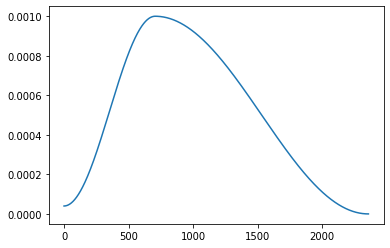

In [28]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in cfg.mri_types]
    print(modelfiles)

## Predict Function

In [ ]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device)).cpu().numpy().squeeze())
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

### Ensemble for Validation

In [ ]:
df_valid = df_valid.set_index("BraTS21ID")

In [ ]:
def normalize_results(preds, train):
    return (preds - (preds.mean() - train.mean()))

In [ ]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])